<a href="https://colab.research.google.com/github/Shivabairy005/Machine-Learning-Lab/blob/main/customer_satisfaction_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing important libraries and functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LogisticRegression

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


loading a dataset

In [52]:
filepath2 = '/content/drive/MyDrive/Machine Learning Dataset/Santander Customer Satisfaction_train.csv'
df2 = pd.read_csv(filepath2)
print(df2.shape)

(76020, 371)


In [53]:
[col for col in df2.columns if df2[col].isnull().sum()>0] #checking for null values

[]

Constant Features (columns with constant values)

In [54]:
x_train2 , x_test2 , y_train2 , y_test2 = train_test_split(
    df2.drop(labels=['saldo_medio_var44_ult3'],axis=1),
    df2['saldo_medio_var44_ult3'],
    test_size=0.3,
    random_state=0
)
print(x_train2.shape)
print(x_test2.shape)

(53214, 370)
(22806, 370)


In [57]:
constant_features2 = [ cols for cols in x_train2.columns if x_train2[cols].std() == 0 ]
print(len(constant_features2))

0


In [56]:
x_train2.drop(labels = constant_features2 , axis=1 , inplace = True)
x_test2.drop(labels = constant_features2 , axis=1 , inplace = True)

Quasi Constant Features (98% of the values of a column are same or constant)

In [61]:
quasi_constant_feature = []

for feature in x_train2.columns:
  predominant = (x_train2[feature].value_counts() / np.float64(len(x_train2))).sort_values(ascending=False).values[0]

  if predominant > 0.999:
    quasi_constant_feature.append(feature)

print(len(quasi_constant_feature))

0


In [60]:
x_train2.drop(labels = quasi_constant_feature , axis=1 , inplace = True)
x_test2.drop(labels = quasi_constant_feature , axis=1 , inplace = True)

Duplicated Columns (Two or More Cols having same duplicated values)

In [63]:
duplicated_feat = []

for i in range(0,len(x_train2.columns)):
  col_1 = x_train2.columns[i]
  for col_2 in x_train2.columns[i+1:]:
    if x_train2[col_1].equals(x_train2[col_2]):
      duplicated_feat.append(col_2)

print(duplicated_feat)

['ind_var26', 'ind_var25', 'ind_var32', 'ind_var37', 'ind_var39', 'num_var26', 'num_var25', 'num_var32', 'num_var37', 'num_var39']


In [64]:
duplicated_features = list(set(duplicated_feat))
x_train2.drop(labels = duplicated_features , axis=1 , inplace = True)
x_test2.drop(labels = duplicated_features , axis=1 , inplace = True)

Corelation Heat Map

<Axes: >

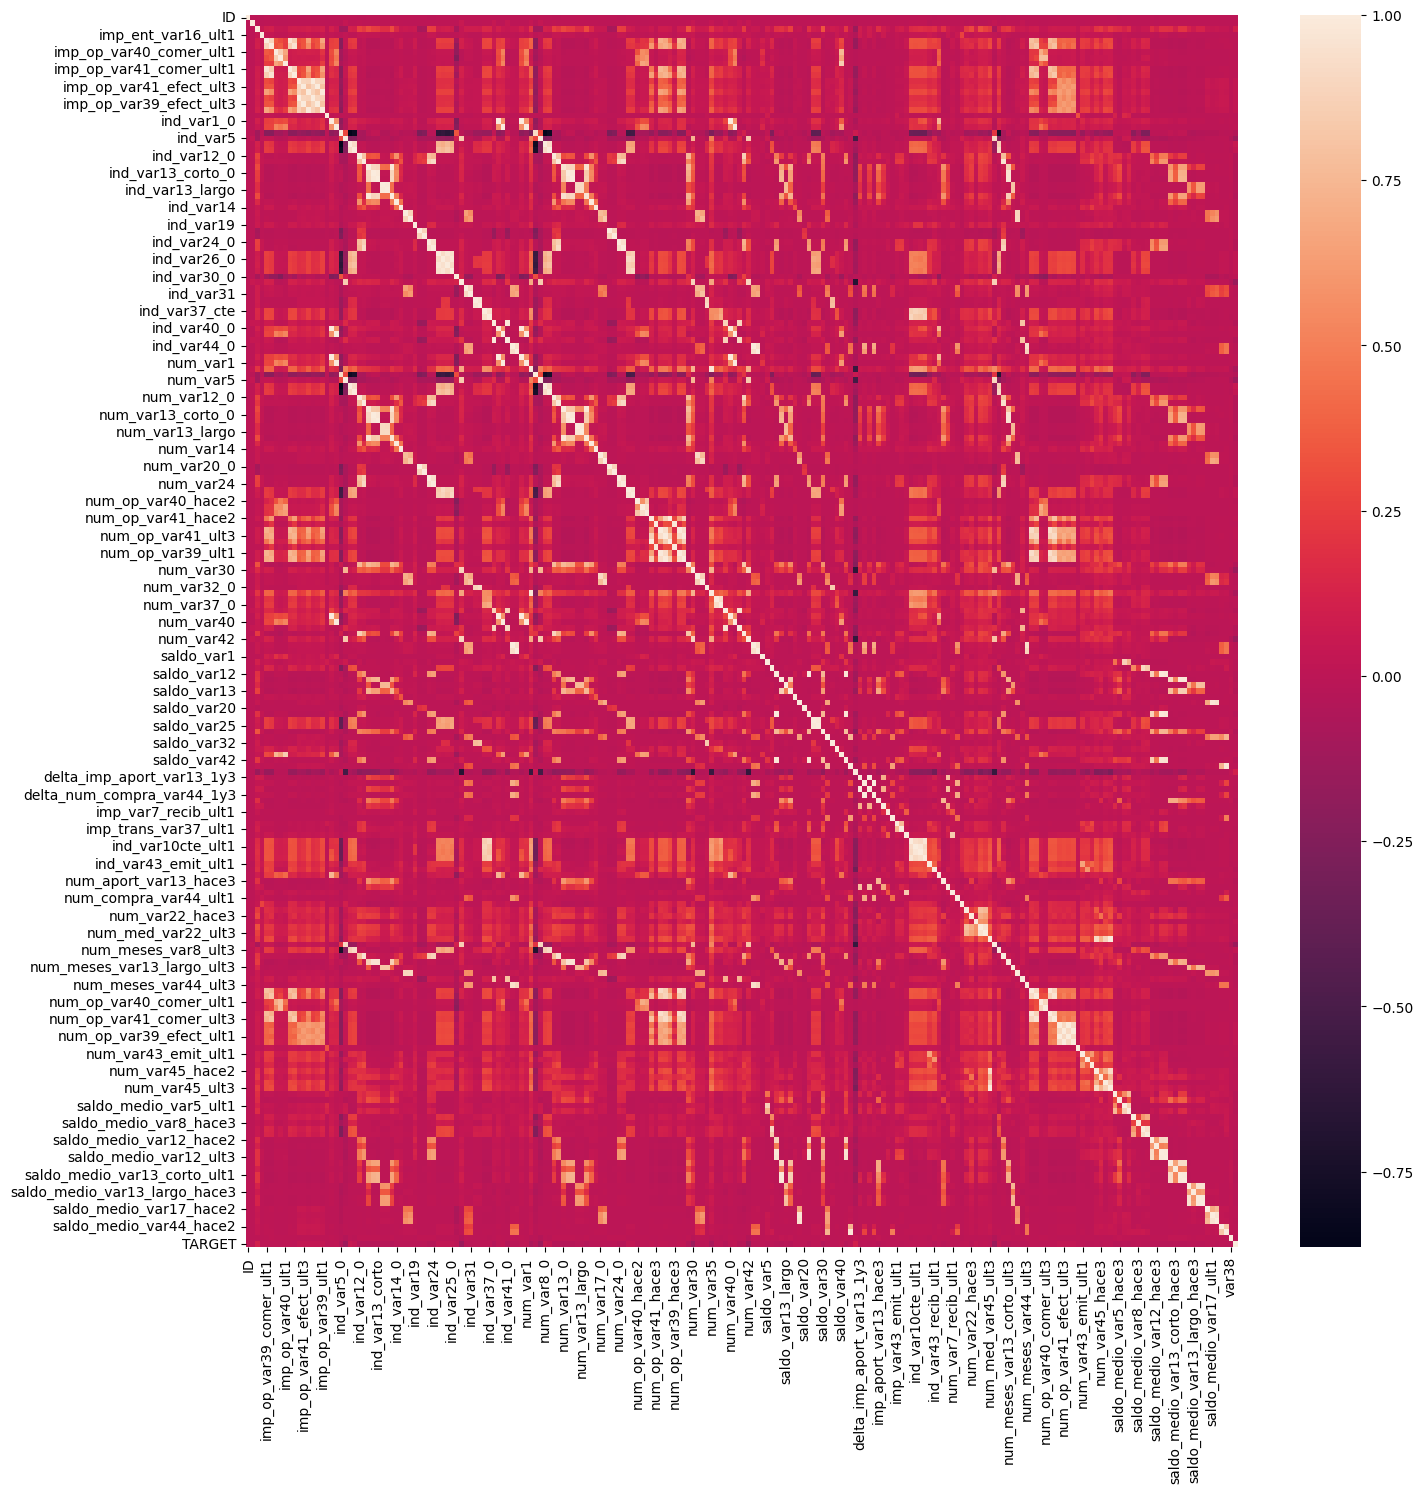

In [ ]:
corrmat = x_train2.corr()
fig , ax = plt.subplots()
fig.set_size_inches(16,16)
sns.heatmap(corrmat)

In [66]:
grouped_feature_ls = []
correlated_features_ls = []
def correlation(dataset , threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

corr_features = correlation(x_train2 , 0.9)
correlated_features = list(set(corr_features))
print(len(correlated_features))

93


In [67]:
x_train2.drop(labels = correlated_features , axis=1 , inplace = True)
x_test2.drop(labels = correlated_features , axis=1 , inplace = True)

Mutual Information

In [69]:
X = x_train2.drop(columns=['TARGET'])
Y = x_train2['TARGET']
mi_scores = mutual_info_classif(X,Y)
mi_df = pd.DataFrame({'Feature':X.columns,'Mutual Info Score':mi_scores})
mi_df.sort_values('Mutual Info Score',ascending=False)


threshold = 0.01
dropped_features = mi_df[mi_df['Mutual Info Score'] <= threshold]['Feature']
x_train2.drop(columns=dropped_features, inplace=True)

In [70]:
x_test2.drop(columns=dropped_features, inplace=True)

Chi Square Test to select useful features

In [79]:
X = x_train2.drop(columns=['TARGET'])
Y = x_train2['TARGET']
label_encoders = {}
for col in X.columns:
  if X[col].dtype == 'object' :
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Replace negative values with 0
X = X.clip(lower=0)

if Y.dtype == 'object':
  Y = LabelEncoder().fit_transform(Y.astype(str))

chi_score , p_values = chi2(X,Y)
chi_df = pd.DataFrame({'Feature':X.columns,'Chi Square Score':chi_score, 'P Values':p_values})
chi_df.sort_values('Chi Square Score',ascending=False)
features_drop = chi_df[chi_df['P Values'] > 0.05]['Feature']
x_train2.drop(columns=features_drop, inplace=True)
x_test2.drop(columns=features_drop, inplace=True)

ANOVA

In [85]:
X = x_train2.drop(columns=['TARGET'])
y = x_train2['TARGET']
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y.astype(str))
X_num = X.select_dtypes(include=['number'])
f_scores, p_values = f_classif(X_num, y)
f_df = pd.DataFrame({'Feature': X_num.columns, 'F-Score': f_scores, 'P-Value': p_values})
f_df.sort_values('F-Score', ascending=False)

features_to_drop = f_df[f_df['P-Value'] > 0.05]['Feature']
x_train2.drop(columns=features_to_drop, inplace=True)
x_test2.drop(columns=features_to_drop, inplace=True)